In [1]:

import matplotlib.pyplot as plt
import itertools
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.datasets as dset
import torchvision.transforms as transforms
import tensorflow_datasets as tfds
import torchvision
from tensorflow.keras.datasets import cifar10

from torch.autograd import Variable
from torch.utils.data.dataset import Dataset

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


# In[2]:


## All Hyperparams should go here. CGAN, CAEGAN, ICAEGAN
img_size = 256 # can use this to mofidy data size to fit this model
n_epochs = 10 #50? depends on max_sampels
print_stride = 1
bs = 16 # 64

z_dim = 100

learning_rate = 0.0002



Files already downloaded and verified
Files already downloaded and verified
torch.Size([16, 3, 256, 256])
torch.Size([16])
tensor(-0.9733) tensor(0.7319)
tensor(0)


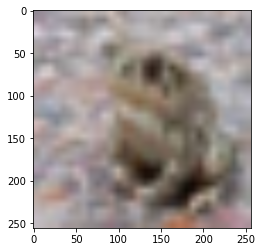

In [2]:

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Resize(img_size),
     transforms.Normalize([0.5], [0.5])])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=bs,
                                          shuffle=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(testset, batch_size=bs,
                                         shuffle=False)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

print(next(iter(train_loader))[0].shape)
print(next(iter(train_loader))[1].shape)

first_samp = next(iter(train_loader))[0][0]
print(torch.min(first_samp), torch.max(first_samp))
plt.imshow(0.5*(first_samp.permute(1,2,0) + 1))

print(next(iter(train_loader))[1][0])



In [11]:

class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        ## Encoding: Unconditional samples
        self.conv1 = nn.Conv2d(3, 64, 4, 2, 1) # Input: (bs, 3, img_size, img_size)
        self.conv2 = nn.Conv2d(64, 128, 4, 2, 1, bias = False)
        self.conv2_bn = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(128, 256, 4, 2, 1, bias = False)
        self.conv3_bn = nn.BatchNorm2d(256)
        self.conv4 = nn.Conv2d(256, 512, 4, 2, 1, bias = False)
        self.conv4_bn = nn.BatchNorm2d(512)
        
        self.conv5 = nn.Conv2d(512, 1024, 4, 2, 1, bias = False)
        self.conv5_bn = nn.BatchNorm2d(1024)
        
        
        self.conv6 = nn.Conv2d(1024, 2048, 4, 2, 1, bias = False)
        self.conv7 = nn.Conv2d(2048, z_dim, 4, 2, 0) # Output: (bs, c_dim, 1, 1)
        

        ## Decoding:
        self.deconv1 = nn.ConvTranspose2d(z_dim, 1024, 4, 1, 0, bias = False) # Not sure how this looks
        self.deconv1_bn = nn.BatchNorm2d(1024)
        self.deconv2 = nn.ConvTranspose2d(1024, 512, 4, 2, 1, bias = False)
        self.deconv2_bn = nn.BatchNorm2d(512)
        self.deconv3 = nn.ConvTranspose2d(512, 256, 4, 2, 1, bias = False)
        self.deconv3_bn = nn.BatchNorm2d(256)
        self.deconv4 = nn.ConvTranspose2d(256, 128, 4, 2, 1, bias = False)
        self.deconv4_bn = nn.BatchNorm2d(128)
        
        self.deconv5 = nn.ConvTranspose2d(128, 64, 4, 2, 1, bias = False)
        self.deconv5_bn = nn.BatchNorm2d(64)
        
        self.deconv6 = nn.ConvTranspose2d(64, 32, 4, 2, 1, bias = False)
        
        self.deconv7 = nn.ConvTranspose2d(32, 3, 4, 2, 1, bias = False)


    def weight_init(self):
        for m in self._modules:
            normal_init(self._modules[m])

    def encode(self, x):
        # Encode data x to 2 spaces: condition space and variance-space
        print('enter encode', x.shape)
        x = F.leaky_relu(self.conv1(x), 0.2)
        print(x.shape)
        x = F.leaky_relu(self.conv2_bn(self.conv2(x)), 0.2)
        print(x.shape)
        x = F.leaky_relu(self.conv3_bn(self.conv3(x)), 0.2)
        print(x.shape)
        x = F.leaky_relu(self.conv4_bn(self.conv4(x)), 0.2)
        print(x.shape)
        x = F.leaky_relu(self.conv5_bn(self.conv5(x)), 0.2)
        print(x.shape)
        x = self.conv6(x)
        print(x.shape)
        z = torch.sigmoid(self.conv7(x))
        #z = torch.sigmoid(self.conv5(x)) # Variance-space unif~[0,1]
        print(z.shape)
        return z

    def decode(self, z):
        print('enter decode', z.shape)
        x = self.deconv1_bn(self.deconv1(z))
        print(x.shape)
        x = F.relu(self.deconv2_bn(self.deconv2(x)))
        print(x.shape)
        x = F.relu(self.deconv3_bn(self.deconv3(x)))
        print(x.shape)
        x = F.relu(self.deconv4_bn(self.deconv4(x)))
        print(x.shape)
        x = F.relu(self.deconv5_bn(self.deconv5(x)))
        print(x.shape)
        x = self.deconv6(x)
        print(x.shape)
        x = self.deconv7(x)
        return torch.tanh(x)

    def forward(self, x):
        return self.decode(self.encode(x))


def normal_init(m):
    if isinstance(m, nn.ConvTranspose2d) or isinstance(m, nn.Conv2d):
        m.weight.data.normal_(0.0, 0.02)
        #m.bias.data.zero_()

def one_hot_embedding(labels):
    labels = torch.nn.functional.one_hot(torch.tensor(labels).to(torch.int64), num_classes = c_dim)
    return torch.squeeze(labels)


def print_g_sample():
    with torch.no_grad():
        codes = one_hot_embedding(torch.tensor(list(range(9)), device = device)).view(9,c_dim,1,1).float()
        varis = torch.randn((9, v_dim,1,1), device = device) # walk from [0,...,0] to [1,...,1]
        generated = .5*(G(varis, codes).cpu() + 1)
        for i in range(9):
            plt.subplot(330 + 1 + i)
            # plot raw pixel data
            element = generated[i,:].permute(1,2,0)
            plt.imshow(element)
        plt.show()


In [12]:
AE = Autoencoder()
AE.weight_init()
AE.to(device)

bce_loss = nn.BCELoss()
mse_loss = nn.MSELoss()
mae_loss = nn.L1Loss()
learning_rate = 0.0002
beta_1 = 0.5
beta_2 = 0.999

AE_optimizer = optim.Adam(AE.parameters(),
                         lr = learning_rate,
                         betas = (beta_1, beta_2))


AE_loss_tracker = []
for epoch in range(1, n_epochs+1):

    AE_losses = []

    for X, y in train_loader:
        mini_batch = X.size()[0]
        X = X.to(device)
        y = y.to(device)

        ## Generator Training
        for param in AE.parameters():
            param.grad = None

        Xhat = AE(X)
        
        AE_loss = mse_loss(Xhat, X)
        
        model_loss = AE_loss

        model_loss.backward()
        AE_optimizer.step()

        AE_losses.append(AE_loss.data.item())
        
        break
    break

    if epoch % print_stride == 0:
        print('Epoch {} - loss_AE: {:.3f}'.format((epoch), torch.mean(torch.FloatTensor(AE_losses))))

        G_loss_tracker.append(torch.mean(torch.FloatTensor(G_losses)))
        print_g_sample()

enter encode torch.Size([16, 3, 256, 256])
torch.Size([16, 64, 128, 128])
torch.Size([16, 128, 64, 64])
torch.Size([16, 256, 32, 32])
torch.Size([16, 512, 16, 16])
torch.Size([16, 1024, 8, 8])
torch.Size([16, 2048, 4, 4])
torch.Size([16, 100, 1, 1])
enter decode torch.Size([16, 100, 1, 1])
torch.Size([16, 1024, 4, 4])
torch.Size([16, 512, 8, 8])
torch.Size([16, 256, 16, 16])
torch.Size([16, 128, 32, 32])
torch.Size([16, 64, 64, 64])
torch.Size([16, 32, 128, 128])
